# Importar Librarias y datos

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [85]:
df = pd.read_parquet("output_08.parquet")

In [86]:
df.head()

,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,...,tax_status_Otro,tax_status_Single,citizenship_Native,citizenship_Otro,country_of_birth_own_US,migration_code_change_in_msa_MSA to MSA,migration_code_change_in_msa_Otro,migration_code_change_in_msa_unchanged,migration_code_change_in_reg_Otro,migration_code_change_in_reg_unchanged
0,0.853333,1.0,0.0,0.000000,1.000000,0.000000,0.333333,0.0,0.0,0.002916,...,True,False,True,False,True,False,False,False,False,False
1,0.666667,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
2,0.080000,0.0,0.0,0.050005,0.288462,0.565217,0.666667,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
4,0.733333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,False,True,False,True,False,False,False,False,False
5,0.400000,0.0,0.0,0.082508,1.000000,0.673913,1.000000,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,True,False,True


In [87]:
df.columns

Index(['age', 'gender', 'employment_stat', 'wage_per_hour',
       'working_week_per_year', 'occupation_code', 'total_employed', 'gains',
       'losses', 'stocks_status', 'income_above_limit',
       'education_secondary_complete', 'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher',
       'marital_status_Married-civilian spouse present',
       'marital_status_Never married', 'marital_status_Otro',
       'marital_status_Widowed', 'race_Otro', 'race_White', 'is_hispanic_Otro',
       'employment_commitment_Full-time schedules',
       'employment_commitment_Not in labor force',
       'employment_commitment_Otro',
       'industry_code_main_Manufacturing-durable goods',
       'industry_code_main_Not in universe or children',
       'industry_code_main_Otro', 'industry_code_main_Retail trade',
       'household_stat_Householder', 'household_stat_Nonfamily Householder',
       'household_stat

# Combinado

In [89]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek

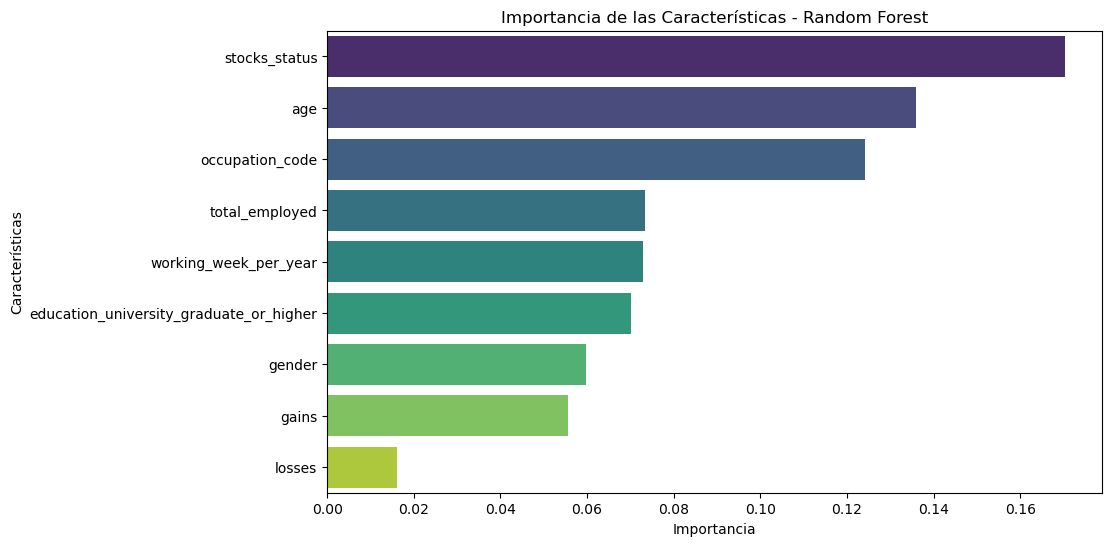

In [90]:
X = df.drop("income_above_limit", axis=1)
y = df["income_above_limit"]

X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

importances = model.feature_importances_
feature_names = X.columns

# order by size
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# create data frame of top 8
features = pd.DataFrame(data=sorted_features[:9], columns=['feature_names', 'importances'])

# create graph
plt.figure(figsize=(10, 6))
sns.barplot(x=features['importances'], y=features['feature_names'], hue=features['feature_names'], palette="viridis", legend=False)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las Características - Random Forest")
plt.show()

# Elegir Features

In [92]:
selected = ['country_of_birth_own_US']
selected += list(features['feature_names'])


# Separar por el modelo

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled[selected], y_resampled, test_size=0.2, random_state=42)

# Probar con varios numeros de Clusters

In [96]:
# La precisión sigue aumentando. Aumente el alcance y la visualización.

accuracies = []

for K in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    #print(f"K value: {K}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}\n")

print(accuracies)

[0.8845981372887203, 0.8996033114867196, 0.8867885477750949, 0.8935322525008623, 0.8854777509486029, 0.8888409796481546, 0.8827009313556399, 0.8856329768885822]


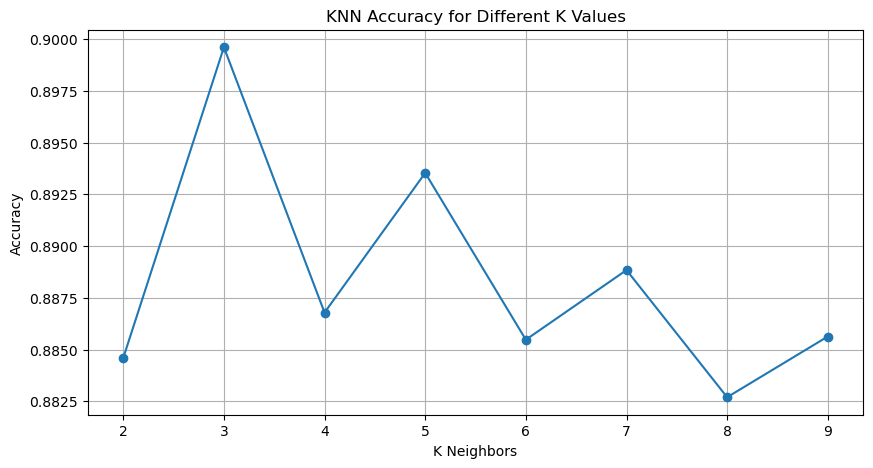

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), accuracies, marker='o', linestyle='-')
plt.xlabel('K Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different K Values')
#plt.xticks(k_values)
plt.grid(True)
plt.show()

# Elegir numero optimo de Clusters

### Mirando ese grafico **3** es que sale con lo mejor presicion

In [99]:
from importlib import reload
import evaluate

reload(evaluate)

<module 'evaluate' from 'C:\\Users\\rossj\\python\\final_project\\evaluate.py'>

In [100]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from evaluate import evaluate_model

In [101]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_probs = knn.predict_proba(X_test)[:, 1]  

roc_score = roc_auc_score(y_test, y_probs)

Accuracy: 0.8996
--------------------------------------------------
Class 0:
    Precision: 0.8918
    Recall: 0.9106
    F1 Score: 0.9011
Class 1:
    Precision: 0.9079
    Recall: 0.8885
    F1 Score: 0.8981
--------------------------------------------------
Specificity: 0.9106
Negative Predictive Value (NPV): 0.8918
ROC score: 0.9452
--------------------------------------------------


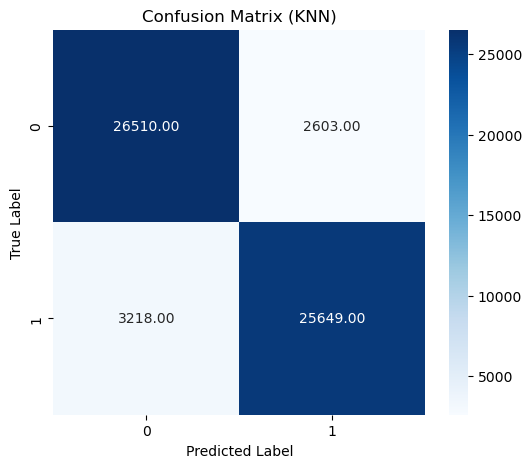

In [102]:
knn_metrics = evaluate_model("KNN combined", y_test, y_pred, roc_score)

# Convert to DataFrame
knn_df = pd.DataFrame([knn_metrics])


# Guardar las metricas

In [104]:
knn_df.to_csv("knn_com.csv")